# DAY 1: Regression


### AM207: Advanced Scientific Computing

#### Instructor: Weiwei Pan

#### Due: September 3rd, 11:59pm EST

**Names of Group Members**: Chi Zhang, Arthur Young, Arnob Roy, Salma Abdel Magid, Ansuman Prusty, Weiru Chen



## Learning Goals:

1. become familiar with using `sklearn` and `numpy` for Linear and Bayesian Linear Regression
2. explore the difference between probabilistic and non-probabilistic models for linear regression
3. learn how to interpret and evaluate probabilistic models
4. explore the difference between Bayesian and non-Bayesian probabilistic models for linear regression
4. lean how to interpret and evaluate Bayesian models

In [15]:
# import the necessary python libraries
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

### We include some auxiliary functions that we will need to use later.

In [1]:
def generate_toy_data(n_points=20, noise_std=0.05):
    ''' Function to generate a toy dataset '''
    x = np.linspace(-5, 5, n_points)
    x_test = np.linspace(-5, 5, 50)

    #define a function relating input to output
    f = lambda x: 0.01 * x**3

    #generate noisy training labels
    y = f(x) + np.array([np.random.normal(0, noise_std * x_n**2) for x_n in x])
    y_test = f(x_test) + np.array([np.random.normal(0, noise_std * x_n**2) for x_n in x_test])
    
    return x, y, x_test, y_test

def get_posterior_samples(w0_prior_var, w1_prior_var, noise_var, x_matrix, y_matrix, x_test_matrix, samples=100):
  ''' Function to generate samples from the posterior and posterior predictive of a Bayesian linear model '''
  #define the variances of the normal priors for w_0 and w_1
  #note that rather than treating the normal priors for w_0 and w_1 separately,
  #we can jointly express this prior as a bivariate normal distribution with a diagonal covariance matrix
  prior_variance = np.diag([w0_prior_var, w1_prior_var])
  #define the inverse of the prior variance, this is called the precision
  prior_precision = np.linalg.inv(prior_variance)

  #this 'epsilon' offsett is sometimes needed to ensure numerical stability of the matrix inverse operation
  epsilon = 1e-5

  #compute the posterior precision matrix
  posterior_precision = prior_precision + x_matrix.T.dot(x_matrix) / noise_var
  #invert the precision matrix to get the posterior covariance matrix
  posterior_variance = np.linalg.inv(posterior_precision + epsilon * np.ones(x_matrix.shape[1])) 
  #compute hte posterior mean
  posterior_mean = posterior_variance.dot(x_matrix.T.dot(y_matrix)) / noise_var

  #sampling 100 points from the posterior distribution over w_0 and w_1
  posterior_samples = np.random.multivariate_normal(posterior_mean.flatten(), posterior_variance, size=samples)

  #take posterior predictive samples
  posterior_predictions = np.dot(posterior_samples, x_test_matrix.T) 
  posterior_predictive_samples = posterior_predictions[np.newaxis, :, :] + np.random.normal(0, noise_var**0.5, size=(100, posterior_predictions.shape[0], posterior_predictions.shape[1]))
  posterior_predictive_samples = posterior_predictive_samples.reshape((100 * posterior_predictions.shape[0], posterior_predictions.shape[1]))

  return posterior_samples, posterior_predictions, posterior_predictive_samples

## 1. Non-Probabilistic Models: Choosing a Loss Function 
In this problem, you are going to explore the difference between the different possible loss functions for fitting a linear model to a data set.

1. **(Max absolute deviation)** Count only the biggest "error"
$$
\max_n |y_n - \hat{y}_n| 
$$
2. **(Sum of absolute deviations)** Add up all the "errors"
$$
\sum_n |y_n - \hat{y}_n| 
$$
3. **(Sum of squared errors)** Add up the squares of the "errors"
$$
\sum_n |y_n - \hat{y}_n|^2 
$$
4. **(Mean squared error)** We can also average the squared "errors".
$$
\frac{1}{N}\sum_{n=1}^N |y_n - \hat{y}_n|^2 
$$

Again, $y_n$ is the observed target, $\hat{y}_n$ is the predicted target.

Fitting a linear model 
$$
y = w_1x + w_0
$$
to the data using one of these loss functions is a non-probablistic approach, since our model does not explicitly model the observation noise. Note that the choice of the mean squared error implies a probabilistic model (this is something you'll explore in HW0).

**Exercise 1:** Describe one real-life application wherein it would be more appropriate to use max absolute deviation rather than mean squared error.

**Exercise 2:** Describe one real-life application wherein it would be more appropriate to use sum of squared errors rather than max absolute deviation.

**Exercise 3:** Describe why it might be more preferable to use mean squared error rather than sum of squared errors.

**Exercise 4:** Describe qualitatively the difference between penalizing sum of absolute deviations and sum of squared errors. 

***Hint:*** think about which kinds of errors are heavily penalized under each loss function and which kinds of errors are 'tolerated' by each loss function.

1, max absolute deviation penalize the maxium of the error.This applies to models with errors deviate from guassian. It can be used to find outliers, that's not possible with MSE. If the risk of prediction error is really high stake, for example high financial impact, matter of life and death, we may prefer to use max absolute deviation.    
2, sum of squared errors penalize the overall error and is most commonly used for guassian errors. It can be used to compare performance of different models using the same dataset. For example, comparing performance of Randomforest classifier vs SVM classifier.  Real life application is an example of fitting a line where we need to find prices of properties for a given square-feet. If we are evaluating the average performance, we may prefer sum squared error.     
3, Mean squared error can be used to compare models with different number of samples. For example, comparing model performance of training vs testing set. Sum squared error is proportional to sample size.    
4, If there are large variations, the squared error would penalize more on data that have large devidations from the model compared to absolute error. Absolute error would be less sensitive to outliers. L1 is not differentiable, L2 is and has a closed-form solution. 


---

## 2. Probabilistic Models: Linear Regression

In this problem, you are given a dataset with a single predictor $X$ and a single outcome $y$, and your task is to fit a linear model to the data. 

Assume that the outcome $y$ can be modeled by the following **probabilistic** or **statistical** model (so called because we explicitly model the observation noise $\epsilon$):
\begin{aligned}
y &= f(x) + \epsilon = w_1x + w_0 + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.5)
\end{aligned}
where $w_1$ and $w_0$, the *parameters* of the function $f$, are unknown constants. 

We learn the maximum likelihood estimates of the slope $w_1$ and the intercept $w_0$ (using `sklearn`), and visualize the resulting MLE linear model.


In [3]:
# Step 0. generate a data set for doing regression
x_train, y_train, x_test, y_test = generate_toy_data(n_points=200) 

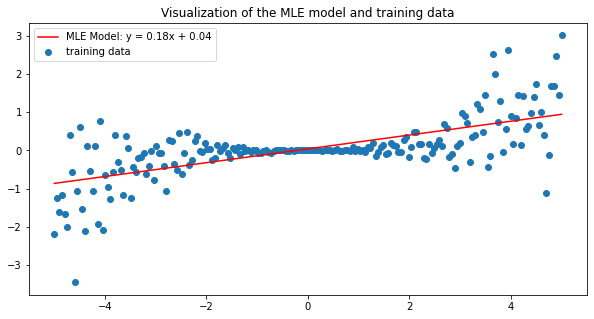

In [4]:
# Step 1. Instantiate an Linear Regression model object
linear_regressor = LinearRegression()

# Step 2. Fit model to the training data
linear_regressor.fit(x_train.reshape(-1,1),y_train.reshape(-1,1))

# Step 3. Make predictions on training data 
y_train_pred = linear_regressor.predict(x_train.reshape(-1,1))

# Step 4. Extract the MLE for slope
slope_mle = np.round(linear_regressor.coef_[0][0], 2)

# Step 5. Extract the MLE for intercept
intercept_mle = np.round(linear_regressor.intercept_[0], 2)

# Step 6. Visualize results

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# make a figure with one row and one column of size 10x5

ax.scatter(x_train, y_train, label='training data')
# scatter plot the training data

ax.plot(x_train, y_train_pred, 'r', label='MLE Model: y = {}x + {}'.format(slope_mle, intercept_mle))
# plot the learned linear regression function by plotting the predictions

ax.set_title('Visualization of the MLE model and training data')

ax.legend(loc='best')
# display legend

plt.show()
# display the figure

**Exercise 5:** Compute the Mean Square Error (MSE) of your model on the training dataset and on the testing dataset.

Compute the residuals on the training data. Visualize these residuals in a histogram. 

In [5]:
# Hint: you can use a pre-defined MSE function in the library documentation at: 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
#
## COMPLETE
from sklearn.metrics import mean_squared_error

training_mse = mean_squared_error(y_train, y_train_pred)
y_test_pred = linear_regressor.predict(x_test.reshape(-1,1))
test_mse = mean_squared_error(y_test, y_test_pred)
#
print('MSE on training data is: {}'.format(training_mse))
print('MSE on test data is: {}'.format(test_mse))

MSE on training data is: 0.36425591026397686
MSE on test data is: 0.47853633637436443


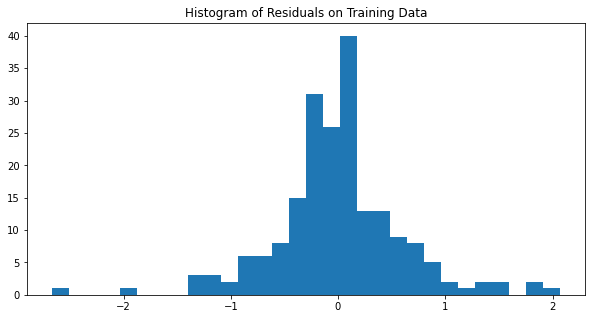

In [6]:
## COMPLETE
# Compute residuals
residuals = y_train.reshape(-1,1) - y_train_pred
#
# Visualize residuals
fig, ax = plt.subplots(1, 1, figsize=(10, 5)) # make a figure with one row and one column of size 10x5
#
# see documentation for the '.hist()' plotting function here:
# https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html
ax.hist(residuals, bins=30)
#
ax.set_title('Histogram of Residuals on Training Data')
plt.show()

**Exercise 6:** Is a linear model appropriate for this data? Is our linear probabilistic model appropriate for this data? Why or why not? 

Based on your answer, suggest a way to improve our probabilistic model.

Support your answer using concepts you learned from lecture, the visualizations of the data and the model, the resicual, the MSE etc.


**Exercise 7:** Based on your explorations, compare the paradigms of non-probabilistic and probablistic modeling. What are the pros and cons of each approach (what are the advantages of explicitly modeling the observation noise? when should we pick a loss function that does not arise from an explicit noise model?)? 

6, Linear model is not appropriate. We can see that the data points close to x=0 fits the model well but data close to the two ends have large residuals. The linear model assumes the error should be independent of x levels.   
To improve, we can do polynomial regression. Even if we fit a cubic function, the error would still be large. We may think about restrict the domain to x close to 0. We may also need a different error model to explictly model the noise to be related to x levels         
The residue histogram looks normal or heavy tail T distribution.     
7, The advantage of explicitly modeling the observation noise is that when the noise model is correctly specified, the model would be give us accurate predictions and give us the ability to do inferences on p values and confidence intervals. When the observation error do not fit any models, it's best to pick a loss function that does not arise from explicit noise model, although we won't get the benefit of getting p values and confidence intervals. And it is easier to compare models with explicit error models. The predictions would be more robust this way. Also some noise can be difficult to model and non-linear and we may need to directly pick a loss function. Another pro for error modeling is it can incorporate prior beliefs about your noise (posteriors)


---

## 3. Bayesian Models: Bayesian Linear Regression

In this problem, your task is to perform Bayesian linear regression on the same dataset as in Problem 2.

Assume that the outcome $y$ can be modeled by the following process:
\begin{aligned}
y &= f(x) + \epsilon = w_1x + w_0 + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.5)\\
w_0 &\sim \mathcal{N}(0, 1)\\
w_1 &\sim \mathcal{N}(0, 0.5)
\end{aligned}
In this model, we assume the same likelihood as in Part I, but we also include priors for $w_0$ and $w_1$: $p(w_0) = \mathcal{N}(0, 1)$, $p(w_1) = \mathcal{N}(0, 0.5)$.

In HW0, you'll verify that the posterior over $w_1$ and $w_0$, jointly, is also a (multivariate) normal or **Gaussian** distribution:
$$p(w_1, w_0 | y_1, \ldots y_n, x_1, \ldots, x_n) = \mathcal{N}(\mu, \Sigma)$$
where $\Sigma = 
\left[\begin{matrix}
\sigma_{w_0}^2 & \rho\\
\rho & \sigma_{w_1}^2\\
\end{matrix}\right]$ and $\mu$ are determined by the prior variances, the observation noise variance and the data.

**Exercise 8:** Visualize samples from the posterior $p(w_1, w_0 | y_1, \ldots y_n, x_1, \ldots, x_n)$. Use this and your understanding of Gaussian distributions to ***very roughly*** estimate $\sigma_{w_0}^2, \sigma_{w_1}^2, \rho$. 

The quantities $\sigma_{w_0}^2, \sigma_{w_1}$ are often said to quantify the uncertainty we have about our estimate of $w_0$ and $w_1$. Why does this intuitively make sense? Given the visualization of the posterior samples which parameter are we more certain about?

Discuss what $\rho$ tells us about the relationship between $w_0$ and $w_1$ in the posterior. Why is it important to model $\rho$, instead of just $\sigma_{w_0}^2, \sigma_{w_1}$?

In [7]:
# Step 1: define the observation noise variance
noise_variance = 0.5
# Step 2: define the variance of the normal priors on w_0 and w_1
w0_prior_var = 1.
w1_prior_var = 0.5
# Step 3: define the number of samples to draw from the posterior
samples = 100
# Step 4: concatenate a column of 1's to the training data so that inference computations can be cast as matrix operations (this increases efficiency)
# we do this using the PolynomialFeatures model from sklearn
poly = PolynomialFeatures(1)
x_train_poly = poly.fit_transform(x_train.reshape((-1, 1)))
x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))

# Step 5: get samples from the posterior distribution over w_0 and w_1
posterior_samples, posterior_predictions, posterior_predictive_samples = get_posterior_samples(w0_prior_var, w1_prior_var, noise_variance, x_train_poly, y_train.reshape((-1, 1)), x_train_poly, samples)

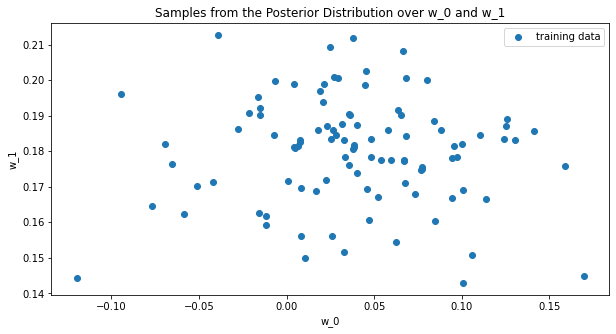

In [8]:
# Step 6. Visualize the posterior samples
fig, ax = plt.subplots(1, 1, figsize=(10, 5)) # make a figure with one row and one column of size 10x5
ax.scatter(posterior_samples[:, 0], posterior_samples[:, 1], label='training data') # scatter plot the training data
ax.set_title('Samples from the Posterior Distribution over w_0 and w_1')
ax.legend(loc='best') # display legend
ax.set_xlabel('w_0') # set the x-axis label
ax.set_ylabel('w_1') # set the y-axis label
plt.show() # display the figure

8, Total of 100 points, remove 5 most extreme points, the range would be 4*std.    
$\sigma_{w_0}^2$ is roughly ((0.07+0.14)/4)^2 = 0.0028, $\sigma_{w_1}^2$ is roughly ((0.2-0.13)/4)^2 = 0.00031, $\rho$ is roughly 0 because the two variables do not show correlation on the plot.  
We are more certain about $w_1$ because the variance is smaller.   
We need model $\rho$ because in the multivariate guassian, $\rho$ determines the covariance of the two parameters and this is not captured by marginal distributions of each variable, which is determined by $\sigma^2$. 



In Bayesian linear regression, we obtain a distribution over possible parameters given the data, $p(w_1, w_0 | y, x)$, rather than a single ***point-estimate*** of the 'best' parameters. This means that when we predict an outcome for, say, $x=2$ we get a distribution over possible values of $y$ rather than a single $y$. The distribution over the predicted $y$ for a given $x$ is called the ***posterior predictive***, and is denoted $p(y|x)$

**Exercise 9:** Visualize the **95% posterior predictive interval** (this is the interval that includes 95% of the posterior predictive values) for the training data -- this is usually visualized as a shaded tube containing the 95% of the posterior predictive values for each test $x$-value. 

The width of the 95% posterior predictive interval is said to quantify the uncertainty of the Bayeisan model at each input $x$. Why is this reasonable?

Compare the 95% posterior predictive interval of our model with the data, are our uncertainties sensible? Are they what you want them to be (you might interpret higher uncertainty at an $x$ to tell you that the model is less confident in it's prediction at $x$)?

In [30]:
# Step 1: compute the 97.5 th percentile of the posterior predictive predictions
pp_upper = np.percentile(posterior_predictive_samples, 97.5, axis=0)
print(pp_upper)

# Step 2: compute the 2.5 th percentile of the posterior predictive predictions
pp_lower = np.percentile(posterior_predictive_samples, 2.5, axis=0)
print(pp_lower)

# Step 3: compute the 50 th percentile of the posterior predictive predictions
pp_mean = np.mean(posterior_predictive_samples, axis=0)
print(pp_mean)

[0.54750018 0.54518011 0.59140537 0.57214367 0.59187068 0.5724201
 0.56855922 0.56815568 0.58449515 0.60233852 0.63722323 0.62806009
 0.64781715 0.62544549 0.66966239 0.63884275 0.69870894 0.67850282
 0.72456914 0.70333874 0.74115134 0.71501545 0.7171365  0.78028158
 0.73578819 0.77899689 0.80082505 0.79546907 0.77254845 0.77768927
 0.77425772 0.83670146 0.82590296 0.83811167 0.87664779 0.90192566
 0.82988269 0.87089656 0.90550553 0.90152427 0.87499322 0.90175573
 0.90708767 0.93811265 0.97374903 0.90695375 0.9829884  0.94471678
 0.95338085 0.98263396 0.96442529 0.96495026 0.99298393 1.00212946
 1.0143893  1.06551024 1.02632141 1.05716349 1.04142557 1.04597316
 1.10453081 1.08690981 1.09560617 1.11031503 1.12010466 1.09049173
 1.14955751 1.13971262 1.11582253 1.14592774 1.17040479 1.18620755
 1.18761372 1.19444023 1.17703438 1.20014238 1.22746523 1.20161251
 1.23081321 1.2098745  1.20781708 1.24673705 1.28393672 1.31062027
 1.29389135 1.25694506 1.30570723 1.3420783  1.31613576 1.34098

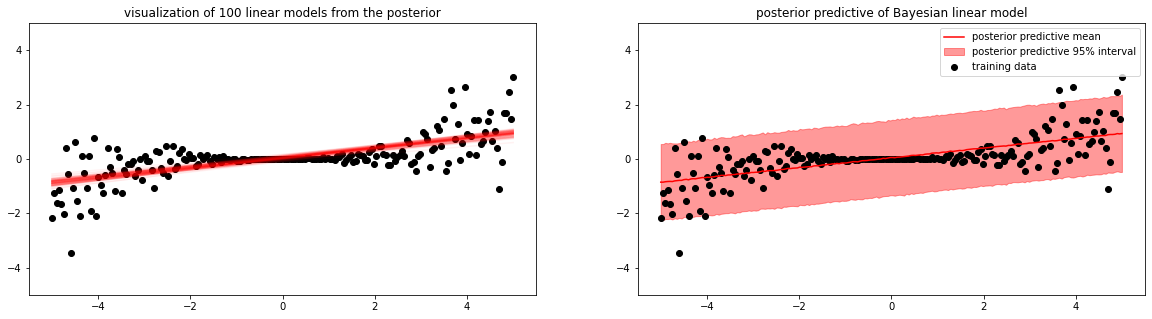

In [27]:
# Step 4: Visualize the posterior predictive distribution
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# visualize the training data 
ax[0].scatter(x_train, y_train, color='black', label='training data') 

# visualize each model from the posterior
for sample in posterior_predictions:
    ax[0].plot(x_train, sample, color='red', alpha=0.05)

ax[0].set_ylim([-5, 5])
ax[0].set_title('visualization of {} linear models from the posterior'.format(samples))

# visualize the mean of the posterior predictive
ax[1].plot(x_train, pp_mean, color='red', label='posterior predictive mean')
# visualize the 95% posterior predictive interval
ax[1].fill_between(x_train, pp_upper, pp_lower, color='red', alpha=0.4, label='posterior predictive 95% interval')
# visualize the training data
ax[1].scatter(x_train, y_train, color='black', label='training data')

ax[1].legend(loc='best')
ax[1].set_title('posterior predictive of Bayesian linear model')
ax[1].set_ylim([-5, 5])
plt.show()

The width of 95% posterior predictive interval quantify the uncertainty at each input x because the data were generated using the specified model and if the model was correct, the posterior distribution should mimic true data.    
In this case, the posterior sampling do not mimic real data. We can see that at points close to x=0, real data have little variability, the variability at two ends are much greater. The simulated data, however, has same variability for all x levels. 